## Setup

In [8]:
import numpy as np
import os
import random
import pandas as pd
from datetime import datetime
import time
import names
from collections import defaultdict
import warnings
from tqdm import tqdm
from hmmlearn import hmm
from typing import List, Tuple
import re 
from collections import Counter
from scipy.stats import pareto
import scipy.stats as stats
warnings.filterwarnings('ignore')

## Markov model

In [34]:
import pandas as pd 
import random
from collections import Counter
from scipy.stats import pareto
import scipy.stats as stats
from scipy.stats import norm, kurtosis
random.seed(1217)
F_dataset = pd.read_json('TBU', orient='records')

def create_powerlaw_p(F_dataset, pareto_alpha):
    #create p
    all_facts = F_dataset["fact"].to_list()
    repetitions = np.array(pareto.rvs(b=pareto_alpha, scale=1, size=len(all_facts)), dtype=int)
    return [f for f, r in zip(all_facts, repetitions) for _ in range(r)]


def create_uniform_p(F_dataset):
    #create p, which is already uniform
    new_facts = F_dataset['fact'].tolist()
    return new_facts

def sample(new_facts, size):
    #sample with replacement
    training_data = random.sample(new_facts, k=size)
    return training_data
    #print out key stats

def mono_calc(new_facts):
    fact_counts = Counter(new_facts)
    num_mono = sum(1 for count in fact_counts.values() if count == 1)
    mono_pct = num_mono / len(new_facts)
    return mono_pct
    
class MovieFactMarkovChain:
    def __init__(self, order):
        self.order = order
        self.transitions = defaultdict(lambda: defaultdict(float))
        self.initial_counts = defaultdict(float)
        self.starts = []
        self.EOS = '<EOS>'
        
    def tokenize_fact(self, fact):
        # Modify this method if city facts have a specific format
        return fact.strip().split()
    
    def calculate_log_probability(self, fact):
        """Calculate log probability for a fact using order-n transitions."""
        tokens = self.tokenize_fact(fact) + [self.EOS]
        if len(tokens) < self.order:
            return np.log(1e-10)
        
        # Start with initial probability in log-space
        start_tokens = tuple(tokens[:self.order])
        log_probability = np.log(self.initial_probs.get(start_tokens, 1e-10))
        
        # Use order-n transitions
        for i in range(len(tokens) - self.order):
            current = tuple(tokens[i:i + self.order])
            next_token = tokens[i + self.order]
            
            # Get transition probability
            trans_prob = self.transitions.get(current, {}).get(next_token, 1e-10)
            log_probability += np.log(trans_prob)
        
        return log_probability
    
    def train(self, facts):
        num_facts = len(facts)
        start_time = time.time()
        
        # First pass: collect transitions
        # print("Collecting transitions...")
        for fact in tqdm(facts, total=num_facts):
            tokens = self.tokenize_fact(fact) + [self.EOS]
            if len(tokens) < self.order + 1:
                continue  # Skip if not enough tokens
            
            start_tokens = tuple(tokens[:self.order])
            self.starts.append(start_tokens)
            self.initial_counts[start_tokens] += 1
            
            for i in range(len(tokens) - self.order):
                current = tuple(tokens[i:i + self.order])
                next_token = tokens[i + self.order]
                self.transitions[current][next_token] += 1

        total_starts = sum(self.initial_counts.values())
        self.initial_probs = {start: count / total_starts for start, count in self.initial_counts.items()}
        
        for current, next_tokens in tqdm(self.transitions.items()):
            total = sum(next_tokens.values())
            for next_token in next_tokens:
                next_tokens[next_token] /= total
                    
        training_time = time.time() - start_time
    
    def generate_facts(self, num_generations):
        """Generate new facts"""
        generated_facts = []
        # print(f"\nGenerating {num_generations:,} facts...")
        
        with tqdm(total=num_generations) as pbar:
            while len(generated_facts) < num_generations:
                # Pick a random start sequence
                current = random.choices(
                    population=list(self.initial_probs.keys()),
                    weights=list(self.initial_probs.values()),
                    k=1
                )[0]
                result = list(current)
                
                # Generate until EOS token is produced
                while True:
                    if current not in self.transitions:
                        break  # Can't continue from here
                    
                    # Get possible next tokens and their probabilities
                    possible_tokens = list(self.transitions[current].keys())
                    probabilities = list(self.transitions[current].values())
                    
                    # Generate next token
                    next_token = np.random.choice(possible_tokens, p=probabilities)
                    if next_token == self.EOS:
                        break  # End of sequence
                    result.append(next_token)
                    
                    # Update current context
                    current = tuple(result[-self.order:])
                
                # Add generated fact
                generated_fact = ' '.join(result)
                generated_facts.append({
                    'fact': generated_fact,
                    'generated': 1
                })
                pbar.update(1)
            
            # Create DataFrame and save
            generated_df = pd.DataFrame(generated_facts)
            
            return generated_df

#-----------------------------------------check hallucinations and calibration-----------------------------------------------
def check_hallucinations(generated_data, training_data, F_dataset):
    """Analyze hallucination rates in generated data
    
    Hallucinations are generated facts that don't exist in F (false statements)
    Not just facts missing from training data O
    """
    generated_facts = set(generated_data['fact'])
    F_facts = set(F_dataset)  # All true facts
    
    # Hallucinations are generated facts not in F
    hallucinations = list(generated_facts - F_facts)
    hallucination_rate = len(hallucinations) / len(generated_data)
    
    # Also calculate "unseen but true" rate
    training_facts = set(training_data)
    unseen_true = list(generated_facts - training_facts - set(hallucinations))
    unseen_true_rate = len(unseen_true) / len(generated_data)
    
    return {
        'hallucination_rate': hallucination_rate,
        'hallucinated_facts': hallucinations,
        'unseen_true_rate': unseen_true_rate,
        'unseen_true_facts': unseen_true
    }

def create_epsilon_induced_bins(epsilon):
   if epsilon < 0:
       raise ValueError("Epsilon must be non-negative")
   if epsilon == 0:
       # For epsilon = 0, we create a bin for each unique probability in g
       # This will be handled in the main calibration function
       return "finest"
   if epsilon >= 1:
       # When epsilon = 1, return single bin for all probabilities
       return [(0, 1)]
   bins = []
   i = 0
   while True:
       upper = (1-epsilon)**i
       lower = (1-epsilon)**(i+1)
       # If lower bound gets very small, make it 0 and make this our last bin
       if lower < 1e-10:
           bins.append((0, upper))
           break
       if upper - lower > 1e-10:
           bins.append((lower, upper))
       i += 1
   return bins

def miscalibration_calc(alpha, p_probs_normalized, g_probs_normalized, epsilon):
    bin_list = []
    miscal_list = []
    alpha_list = []
    
    bins = create_epsilon_induced_bins(epsilon)
    if isinstance(bins, str) and bins == "finest":
       unique_probs = sorted(set(g_probs_normalized), reverse=True)
       bins = [(p, p) for p in unique_probs]

    # Assign facts to bins and calculate sums
    # binned_facts = [[] for _ in range(len(bins))]
    binned_p_sums = [0.0] * len(bins)
    binned_g_sums = [0.0] * len(bins)

    # Bin assignment
    for i, (p_val, g_val) in enumerate(zip(p_probs_normalized, g_probs_normalized)):
       assigned = False
       for bin_idx, (low, high) in enumerate(bins):
          if epsilon != 0:
               if low <= g_val < high:
                   binned_p_sums[bin_idx] += p_val
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
          else:
               if low <= g_val <= high:
                   binned_p_sums[bin_idx] += p_val
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
       if not assigned:
           last_idx = len(bins) - 1
           binned_p_sums[last_idx] += p_val
           binned_g_sums[last_idx] += g_val

    # Calculate miscalibration
    for i in range(len(bins)):
        alpha_list.append(alpha)
        bin_list.append(i)
        miscal_list.append(0.5 * abs(binned_p_sums[i] - binned_g_sums[i]))
    total_miscal = [sum(miscal_list)] * len(miscal_list)
    
    miscal_output = pd.DataFrame({"alpha": alpha_list, "bin": bin_list, "miscal": miscal_list, "total_miscal": total_miscal})
    return miscal_output

def regret_calc(p_probs_normalized, g_probs_normalized, epsilon):
    bin_list = []
    regret_list = []
    
    bins = create_epsilon_induced_bins(epsilon)
    if isinstance(bins, str) and bins == "finest":
       unique_probs = sorted(set(g_probs_normalized), reverse=True)
       bins = [(p, p) for p in unique_probs]

    # Assign facts to bins and calculate sums
    binned_p_sums = [0.0] * len(bins)
    binned_g_sums = [0.0] * len(bins)

    # Bin assignment
    for i, (p_val, g_val) in enumerate(zip(p_probs_normalized, g_probs_normalized)):
       assigned = False
       for bin_idx, (low, high) in enumerate(bins):
          if epsilon != 0:
               if low <= g_val < high:
                   binned_p_sums[bin_idx] += p_val
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
          else:
               if low <= g_val <= high:
                   binned_p_sums[bin_idx] += p_val
                   binned_g_sums[bin_idx] += g_val
                   assigned = True
                   break
       if not assigned:
           last_idx = len(bins) - 1
           binned_p_sums[last_idx] += p_val
           binned_g_sums[last_idx] += g_val

    # Calculate miscalibration
    for i in range(len(bins)):
        bin_list.append(i)
        
        p_B = binned_p_sums[i]     # empirical mass in this bin
        g_B = binned_g_sums[i]     # model mass in this bin
        
        if p_B == 0.0:
            # 0 · log(0 / g_B) is defined as 0
            regret = 0.0
        elif g_B == 0.0:
            # model assigns zero probability where data has positive mass
            regret = float('inf')   # or raise an error / add smoothing
        else:
            regret = p_B * np.log(p_B / g_B) 
            # regret = p_B * np.log(g_B) 
            # regret = p_B * np.log(p_B) 

        regret_list.append(regret)
    total_regret = [sum(regret_list)] * len(regret_list)
    
    reg_output = pd.DataFrame({"bin": bin_list, "regret": regret_list, "total_regret": total_regret})
    
    return reg_output
    
def miscal_analysis(alpha, F_dataset, training_data, model, epsilon):
    all_facts = F_dataset
    fact_counts = Counter(all_facts)
    total_facts = len(all_facts)
    
    facts_list = []
    g_prob_list = []
    p_prob_list = []
    
    raw_g_prob_list = []
    raw_p_prob_list = []

    ##########MISCAL################
    for fact in tqdm(all_facts):
        log_prob = model.calculate_log_probability(fact)
        g_prob = np.exp(log_prob)

        facts_list.append(fact)
        g_prob_list.append(g_prob)
        raw_g_prob_list.append(g_prob)
        
        p_prob = fact_counts[fact] / total_facts
        p_prob_list.append(p_prob)
        raw_p_prob_list.append(p_prob)

    # Normalize g(y) and p(y)
    g_sum = sum(g_prob_list)
    if g_sum > 0:
        g_probs_normalized = [g / g_sum for g in g_prob_list]
    p_sum = sum(p_prob_list)
    if p_sum > 0:
        p_probs_normalized = [p / p_sum for p in p_prob_list]

    ############REGRET#############
    train_facts = training_data
    train_fact_counts = Counter(train_facts)
    train_total_facts = len(train_facts)
    
    train_facts_list = []
    train_g_prob_list = []
    train_p_prob_list = []
    
    train_raw_g_prob_list = []
    train_raw_p_prob_list = []
    
    for train_fact in tqdm(training_data):
        log_prob = model.calculate_log_probability(train_fact)
        g_prob = np.exp(log_prob)
        
        train_facts_list.append(train_fact)
        train_g_prob_list.append(g_prob)
        train_raw_g_prob_list.append(g_prob)
        
        p_prob = train_fact_counts[train_fact] / train_total_facts
        train_p_prob_list.append(p_prob)
        train_raw_p_prob_list.append(p_prob)

    # Normalize g(y) and p(y)
    train_g_sum = sum(train_g_prob_list)
    if train_g_sum > 0:
        train_g_probs_normalized = [g / train_g_sum for g in train_g_prob_list]
    train_p_sum = sum(train_p_prob_list)
    if train_p_sum > 0:
        train_p_probs_normalized = [p / train_p_sum for p in train_p_prob_list]

    #calculate miscalibration
    miscal_output = miscalibration_calc(alpha, p_probs_normalized, g_probs_normalized, epsilon)
    regret_output = regret_calc(train_p_probs_normalized, train_g_probs_normalized, epsilon)
    final_output = pd.merge(miscal_output, regret_output, on='bin', how='left')
    return final_output

## Regular Analysis

In [ ]:
import numpy as np
import os
from collections import defaultdict
import time
from tqdm import tqdm

random.seed(140)

uniform_p = pd.read_json('TBU')
uniform_p = uniform_p[1:20000]
print(uniform_p)
set_order = 2
sample_size = 5000
generation_size = 5000
epsilon = 0.1

hall_rates = []
pareto_alphas = []
mono_pcts = []
miscals = []
lengths_train = []
regrets = []

all_analyses = []

alphas = np.arange(1, 4, 0.01).tolist()
for pareto_alpha in alphas:
    print(f"\nProcessing pareto_alpha: {pareto_alpha}")
    # p distribution
    powerlaw_p = create_powerlaw_p(uniform_p, pareto_alpha)
    training_data = sample(powerlaw_p, sample_size)
    facts_counter = Counter(training_data)
    repeats = list(facts_counter.values())
    mono_rate = mono_calc(training_data)


    #check average and max repeats in p 
    facts_counter_p = Counter(powerlaw_p)
    repeats_p = list(facts_counter_p.values())
    max_repeat_p = max(repeats_p)
    avg_repeat_p = sum(repeats_p) / len(facts_counter_p)
    twenty_fifth_p = np.percentile(repeats_p, 25)
    median_p = np.percentile(repeats_p, 50)
    seventy_fifth_p = np.percentile(repeats_p, 75)
    num_unique_p = len(facts_counter_p.keys())
    mono_rate_p = mono_calc(powerlaw_p)
    
    # fit model
    model = MovieFactMarkovChain(order=set_order)
    model.train(training_data)
    
    #generation path for fact checking
    generated_data = model.generate_facts(generation_size)
    #hallucination results
    hall_results = check_hallucinations(generated_data, training_data, powerlaw_p)

    #miscalibration results
    analysis_results = miscal_analysis(pareto_alpha, powerlaw_p, training_data, model, epsilon)
    all_analyses.append(analysis_results)
    #save results
    mono_pcts.append(mono_rate)
    
    hall_rates.append(hall_results['hallucination_rate'])
    miscals.append(np.mean(analysis_results['total_miscal']))
    regrets.append(np.mean(analysis_results['total_regret']))
    lengths_train.append(len(training_data))
    pareto_alphas.append(pareto_alpha)
    
results_df= pd.DataFrame({
    "Pareto": pareto_alphas,
    'Mono_Pct': mono_pcts,
    "Train_len":lengths_train, 
    "Miscalibration": miscals,
    "Hallucination": hall_rates,
    "CE_reg": regrets
    })

bin_level_results = pd.concat(all_analyses, ignore_index=True) 

print(results_df)

results_df.save_csv("TBU") 
bin_level_results.to_csv("TBU")

       Unnamed: 0  alpha  bin    miscal  total_miscal    regret  total_regret
0               0   1.00    0  0.000000      0.021438  0.000000      0.004266
1               1   1.00    1  0.000000      0.021438  0.000000      0.004266
2               2   1.00    2  0.000000      0.021438  0.000000      0.004266
3               3   1.00    3  0.000000      0.021438  0.000000      0.004266
4               4   1.00    4  0.000000      0.021438  0.000000      0.004266
...           ...    ...  ...       ...           ...       ...           ...
59395       59395   3.99  193  0.000000      0.726294  0.000000      0.554783
59396       59396   3.99  194  0.000000      0.726294  0.000000      0.554783
59397       59397   3.99  195  0.000000      0.726294  0.000000      0.554783
59398       59398   3.99  196  0.000000      0.726294  0.000000      0.554783
59399       59399   3.99  197  0.341317      0.726294  0.004917      0.554783

[59400 rows x 7 columns]


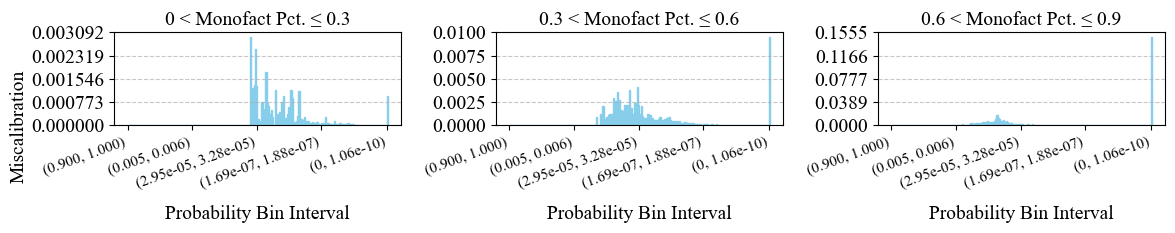

In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

# Set global font to Times New Roman
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14

# Helper function to format bin values in a more readable way
def format_bin_value(value):
    if value == 0:
        return "0"
    elif value < 0.0001:
        return f"{value:.2e}"  # Scientific notation for very small values
    elif value < 0.001:
        return f"{value:.4f}"  # 5 decimal places for small values
    elif value < 0.01:
        return f"{value:.3f}"  # 3 decimal places
    else:
        return f"{value:.3f}"  # 3 decimal places for larger values

# Load data and add bin_interval column
bin_level_results = pd.read_csv("TBU")
results_df = pd.read_csv("TBU") 
results_df.rename(columns={"Pareto": "alpha"}, inplace = True)

print(bin_level_results)
all_bins = create_epsilon_induced_bins(0.1)
bin_level_results['bin_interval'] = bin_level_results['bin'].apply(lambda x: all_bins[x])

bin_level_results = pd.merge(bin_level_results, results_df, on = "alpha", how = "left")

# Format bin intervals using scientific notation for better readability
bin_level_results['bin_interval_str'] = bin_level_results['bin'].apply(
    lambda x: f"({format_bin_value(all_bins[x][0])}, {format_bin_value(all_bins[x][1])})"
)

# Replace the alpha_slices with mono_pct_slices
mono_pct_slices = [(0, 0.3), (0.3, 0.6), (0.6, 0.9)]
fig, axes = plt.subplots(1, 3, figsize=(12, 2.5), sharey=False)
axes = axes.ravel()

for ax, (lo, hi) in zip(axes, mono_pct_slices):
    # left-open, right-closed interval: lo < Mono_Pct ≤ hi
    subset = bin_level_results[bin_level_results["Mono_Pct"]
                            .between(lo, hi, inclusive="right")]
    
    # Group by bin and get mean of miscal for each bin
    bin_groups = subset.groupby('bin')
    means_df = bin_groups['miscal'].mean().reset_index()
    
    # Filter out bins with very small values
    # means_df = means_df[means_df['miscal'] > 0]
    
    # Get the bin intervals for non-zero bins
    means_df = means_df.merge(
        bin_level_results[['bin', 'bin_interval_str']].drop_duplicates(),
        on='bin'
    )
    
    # Sort by bin number
    means_df = means_df.sort_values('bin')
    
    # Get x positions and values for the plot
    x_positions = range(len(means_df))
    bins = means_df['bin_interval_str'].values
    miscal_means = means_df['miscal'].values
    
    # Plot with bin_interval_str on x-axis
    bars = ax.bar(x_positions, miscal_means, color="skyblue", edgecolor="skyblue", width=1)
    
    # Set the bin interval strings as x-tick labels
    ax.set_xticks(x_positions)
    
    # Display ticks - fewer for readability
    n_bins = len(bins)
    if n_bins <= 5:
        tick_indices = range(n_bins)
    else:
        tick_indices = np.linspace(0, n_bins-1, min(5, n_bins), dtype=int)
    
    ax.set_xticks([x_positions[i] for i in tick_indices if i < len(x_positions)])
    ax.set_xticklabels([bins[i] for i in tick_indices if i < len(bins)], 
                      rotation=20, ha='right', fontsize=11)
    
    # Set appropriate y limits with a small buffer at the top
    max_val = miscal_means.max() if len(miscal_means) > 0 else 1
    ax.set_ylim(0, max_val * 1.05)  # Add 15% buffer for value labels
    ticks = np.arange(0, max_val * 1.06, (max_val * 1.05/4))
    ax.set_yticks(ticks)
    # Set title and labels with Mono_Pct instead of gamma
    ax.set_title(f"{lo} < Monofact Pct. ≤ {hi}", fontsize=14)
    ax.set_xlabel("Probability Bin Interval", labelpad=10, fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    
    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Apply scientific notation to y-axis for better readability
    ax.ticklabel_format(style='plain', axis='y')

# A single common y-label
fig.text(0.02, 0.5, "Miscalibration", va="center", rotation="vertical", fontsize=14)

# Adjust layout for better spacing
plt.subplots_adjust(bottom=0.25, wspace=0.3)
plt.tight_layout(rect=[0.02, 0.03, 1, 1.05])

# Save figure with high quality settings
plt.savefig("TBU", 
            dpi=600, bbox_inches='tight', pad_inches=0.05)

plt.show()

In [332]:
all_bins = create_epsilon_induced_bins(0.1)
print(len(all_bins))

198


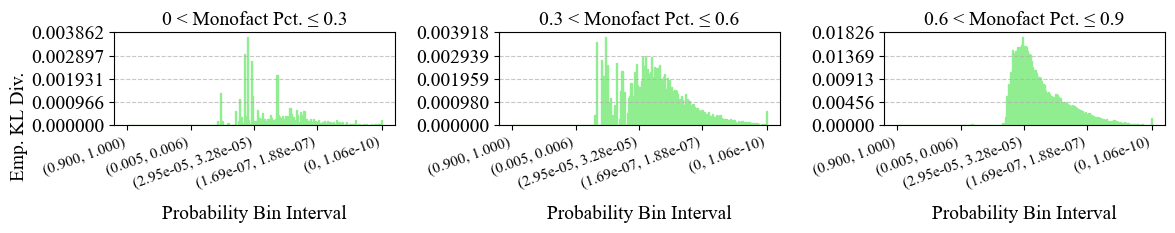

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter

# Set global font to Times New Roman
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14

# Helper function to format bin values in a more readable way
def format_bin_value(value):
    if value == 0:
        return "0"
    elif value < 0.0001:
        return f"{value:.2e}"  # Scientific notation for very small values
    elif value < 0.001:
        return f"{value:.4f}"  # 5 decimal places for small values
    elif value < 0.01:
        return f"{value:.3f}"  # 4 decimal places
    else:
        return f"{value:.3f}"  # 3 decimal places for larger values

# Load data and add bin_interval column
bin_level_results = pd.read_csv("TBU")
results_df = pd.read_csv("TBU") 
results_df.rename(columns={"Pareto": "alpha"}, inplace = True)

bin_level_results = bin_level_results[bin_level_results["bin"]]

all_bins = create_epsilon_induced_bins(0.1)
bin_level_results['bin_interval'] = bin_level_results['bin'].apply(lambda x: all_bins[x])

bin_level_results = pd.merge(bin_level_results, results_df, on = "alpha", how = "left")

# Format bin intervals using scientific notation for better readability
bin_level_results['bin_interval_str'] = bin_level_results['bin'].apply(
    lambda x: f"({format_bin_value(all_bins[x][0])}, {format_bin_value(all_bins[x][1])})"
)

# bin_level_results = bin_level_results[(bin_level_results["alpha"] >= 1) & (bin_level_results["alpha"] <= 1.5)] 


# Replace the alpha_slices with mono_pct_slices
mono_pct_slices = [(0, 0.3), (0.3, 0.6), (0.6, 0.9)]
fig, axes = plt.subplots(1, 3, figsize=(12, 2.5), sharey=False)
axes = axes.ravel()

for ax, (lo, hi) in zip(axes, mono_pct_slices):
    # left-open, right-closed interval: lo < Mono_Pct ≤ hi
    subset = bin_level_results[bin_level_results["Mono_Pct"]
                            .between(lo, hi, inclusive="right")]
    
    # Group by bin and get mean of regret for each bin
    bin_groups = subset.groupby('bin')
    means_df = bin_groups['regret'].mean().reset_index()  # Changed from miscal to regret
    
    # Filter out bins with very small values
    # means_df = means_df[means_df['regret'] > 0]  # Changed from miscal to regret
    
    # Get the bin intervals for non-zero bins
    means_df = means_df.merge(
        bin_level_results[['bin', 'bin_interval_str']].drop_duplicates(),
        on='bin'
    )
    
    # Sort by bin number
    means_df = means_df.sort_values('bin')
    
    # Get x positions and values for the plot
    x_positions = range(len(means_df))
    bins = means_df['bin_interval_str'].values
    regret_means = means_df['regret'].values  # Changed from miscal_means to regret_means
    
    # Plot with bin_interval_str on x-axis
    bars = ax.bar(x_positions, regret_means, color="lightgreen", edgecolor="lightgreen", width=1)  # Changed from miscal_means to regret_means
    
    # Set the bin interval strings as x-tick labels
    ax.set_xticks(x_positions)
    
    # Display ticks - fewer for readability
    n_bins = len(bins)
    if n_bins <= 5:
        tick_indices = range(n_bins)
    else:
        tick_indices = np.linspace(0, n_bins-1, min(5, n_bins), dtype=int)
    
    ax.set_xticks([x_positions[i] for i in tick_indices if i < len(x_positions)])
    ax.set_xticklabels([bins[i] for i in tick_indices if i < len(bins)], 
                      rotation=20, ha='right', fontsize=11)
    
    # Set appropriate y limits with a small buffer at the top
    max_val = regret_means.max() if len(regret_means) > 0 else 1  # Changed from miscal_means to regret_means
    ax.set_ylim(0, max_val * 1.05)  # Add 15% buffer for value labels
    ticks = np.arange(0, max_val * 1.06, (max_val * 1.05/4))
    ax.set_yticks(ticks)
    
    # Set title and labels with Mono_Pct instead of gamma
    ax.set_title(f"{lo} < Monofact Pct. ≤ {hi}", fontsize=14)
    ax.set_xlabel("Probability Bin Interval", labelpad=10, fontsize=14)
    ax.tick_params(axis="y", labelsize=14)
    
    # Add grid lines for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Use regular decimal format for y-axis instead of scientific notation
    ax.ticklabel_format(style='plain', axis='y')

# A single common y-label
fig.text(0.02, 0.5, "Emp. KL Div.", va="center", rotation="vertical", fontsize=14)  # Changed from Miscalibration to Regret

# Set the overall title with Mono_Pct instead of gamma
# fig.suptitle("Regret vs. Probability Bin Intervals for Different Monofact Pct. Ranges", fontsize=14, y=0.98)  # Changed title to reflect Regret

# Adjust layout for better spacing
plt.subplots_adjust(bottom=0.25, wspace=0.3)
plt.tight_layout(rect=[0.02, 0.03, 1, 1.05])

# Save figure with high quality settings
plt.savefig("TBU",  # Changed filename to include regret
            dpi=600, bbox_inches='tight', pad_inches=0.05)

plt.show()

#### Binwise analysis for LLM

In [9]:
# — Helper to format bin values —
def format_bin_value(value):
    if value == 0:
        return "0"
    elif value < 0.0001:
        return f"{value:.1e}"
    elif value < 0.001:
        return f"{value:.2f}"
    elif value < 0.01:
        return f"{value:.2f}"
    else:
        return f"{value:.2f}"

# — Helper to build ε-induced bins —
def create_epsilon_induced_bins(epsilon):
    if epsilon < 0:
        raise ValueError("Epsilon must be non-negative")
    if epsilon == 0:
        return "finest"
    if epsilon >= 1:
        return [(0, 1)]
    bins = []
    i = 0
    while True:
        upper = (1 - epsilon)**i
        lower = (1 - epsilon)**(i + 1)
        if lower < 1e-10:
            bins.append((0, upper))
            break
        if upper - lower > 1e-10:
            bins.append((lower, upper))
        i += 1
    bins.append((1.0, 1.0))
    return bins


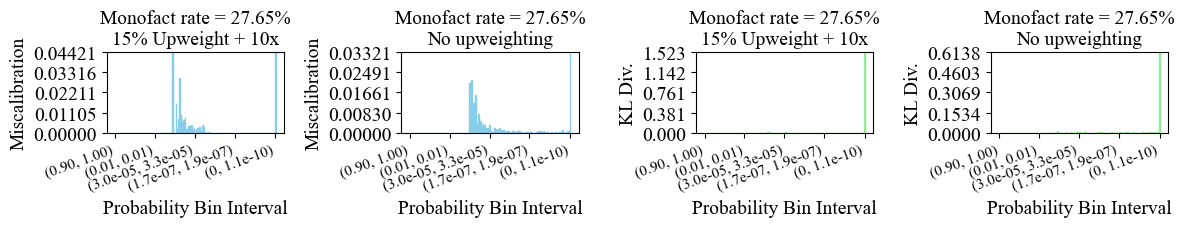

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set global font to Times New Roman with size 14
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14

# Create epsilon-induced bins
epsilon = 0.1
all_bins = create_epsilon_induced_bins(epsilon)

# Load the CSV data
csv_path = "TBU"
csv_path2 = "TBU"
df = pd.read_csv(csv_path)
df2 = pd.read_csv(csv_path2)

# Map each integer bin → (lower, upper) and format as a string
df['bin_interval'] = df['bin'].apply(lambda i: all_bins[i] if i < len(all_bins) else (0, 0))
df['bin_interval_str'] = df['bin_interval'].apply(
    lambda iv: f"({format_bin_value(iv[0])}, {format_bin_value(iv[1])})")

df2['bin_interval'] = df2['bin'].apply(lambda i: all_bins[i] if i < len(all_bins) else (0, 0))
df2['bin_interval_str'] = df2['bin_interval'].apply(
    lambda iv: f"({format_bin_value(iv[0])}, {format_bin_value(iv[1])})")

# Filter out bin 198 as requested
df = df[df["bin"] != 198]
df2 = df2[df2["bin"] != 198]

# Aggregate mean miscalibration and mean KL divergence per bin
means_df = (df.groupby(['bin', 'bin_interval_str'])
             .agg(miscal=('miscal_bin', 'mean'), 
                  kl_div=('regret', 'mean'))
             .reset_index()
             .sort_values('bin'))

means_df2 = (df2.groupby(['bin', 'bin_interval_str'])
              .agg(miscal=('miscal_bin', 'mean'), 
                   kl_div=('regret', 'mean'))
              .reset_index()
              .sort_values('bin'))

# Create figure with 4 subplots in a row
fig, axes = plt.subplots(1, 4, figsize=(12, 2.5))
fig.tight_layout(pad=2.0)  # Add padding between subplots

# Function to add bars with proper formatting and ticks
def plot_bars(ax, means_df, column, color, y_label):
    # Get x positions and values for the plot
    x_positions = range(len(means_df))
    bins = means_df['bin_interval_str'].values
    values = means_df[column].values
    
    # Plot bars
    bars = ax.bar(x_positions, values, color=color, edgecolor=color, width=1)
    
    # Set axis labels
    ax.set_xlabel("Probability Bin Interval", fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    
    # Display ticks - fewer for readability
    n_bins = len(bins)
    if n_bins <= 5:
        tick_indices = range(n_bins)
    else:
        tick_indices = np.linspace(0, n_bins-1, min(5, n_bins), dtype=int)
    
    ax.set_xticks([x_positions[i] for i in tick_indices if i < len(x_positions)])
    ax.set_xticklabels([bins[i] for i in tick_indices if i < len(bins)], 
                      rotation=20, ha='right', fontsize=11)
    
    # Set appropriate y limits with a small buffer at the top
    max_val = max(values)/2 if len(values) > 0 else 1
    ax.set_ylim(0, max_val * 1.05)  # Add 5% buffer
    ticks = np.linspace(0, max_val * 1.05, 5)
    ax.set_yticks(ticks)
    
    return ax

# Plot 1: Miscalibration with df (upweighted)
plot_bars(axes[0], means_df, 'miscal', "skyblue", "Miscalibration")
axes[0].set_title("Monofact rate = 27.65%\n15% Upweight + 10x", fontsize=14)

# Plot 2: Miscalibration with df2 (no upweight)
plot_bars(axes[1], means_df2, 'miscal', "skyblue", "Miscalibration")
axes[1].set_title("Monofact rate = 27.65%\nNo upweighting", fontsize=14)

# Plot 3: KL Div with df (upweighted)
plot_bars(axes[2], means_df, 'kl_div', "lightgreen", "KL Div.")
axes[2].set_title("Monofact rate = 27.65%\n15% Upweight + 10x", fontsize=14)

# Plot 4: KL Div with df2 (no upweight)
plot_bars(axes[3], means_df2, 'kl_div', "lightgreen", "KL Div.")
axes[3].set_title("Monofact rate = 27.65%\nNo upweighting", fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save with the specified path
out_path = "TBU"
plt.savefig(out_path, dpi=600, bbox_inches='tight', pad_inches=0.05)

plt.show()

### Significance test

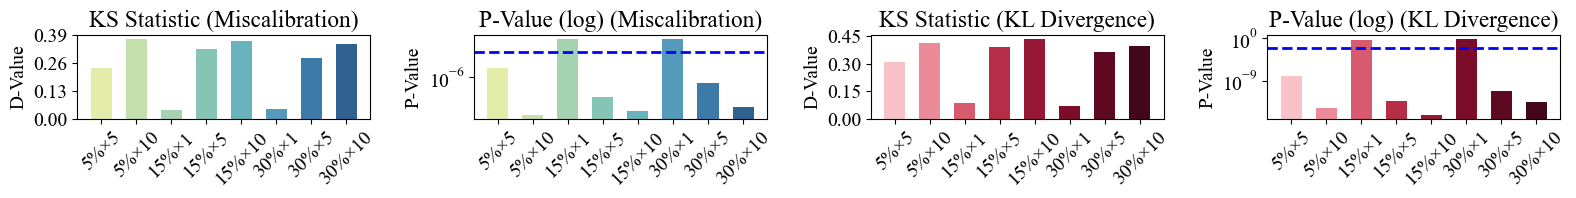

In [276]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# ASSUMES you have already run the two KS‑test blocks that define
# all ks_stat_* and p_value_* variables.  We now bundle them into
# four arrays, one per upcoming subplot.
# ------------------------------------------------------------------

labels = [
    "5%×5", "5%×10",
    "15%×1", "15%×5", "15%×10",
    "30%×1", "30%×5", "30%×10"
]

# ① Miscalibration KS stats + p‑values
ks_stats_miscal = [
    ks_stat_5pct_dup5, ks_stat_5pct_dup10,
    ks_stat_15pct_dup1, ks_stat_15pct_dup5, ks_stat_15pct_dup10,
    ks_stat_30pct_dup1, ks_stat_30pct_dup5, ks_stat_30pct_dup10
]
p_values_miscal = [
    p_value_5pct_dup5, p_value_5pct_dup10,
    p_value_15pct_dup1, p_value_15pct_dup5, p_value_15pct_dup10,
    p_value_30pct_dup1, p_value_30pct_dup5, p_value_30pct_dup10
]

# ② KL‑divergence KS stats + p‑values
ks_stats_div = [
    ks_stat_5pct_dup5_div, ks_stat_5pct_dup10_div,
    ks_stat_15pct_dup1_div, ks_stat_15pct_dup5_div, ks_stat_15pct_dup10_div,
    ks_stat_30pct_dup1_div, ks_stat_30pct_dup5_div, ks_stat_30pct_dup10_div
]
p_values_div = [
    p_value_5pct_dup5_div, p_value_5pct_dup10_div,
    p_value_15pct_dup1_div, p_value_15pct_dup5_div, p_value_15pct_dup10_div,
    p_value_30pct_dup1_div, p_value_30pct_dup5_div, p_value_30pct_dup10_div
]

# --- Colour palettes (the same for stat + p‑value pairs) -------------
palette_greenblue = ["#e4ecaa", "#c5dfad", "#a5d2b1", "#86c5b5",
                     "#69b3bc", "#559aba", "#3e7aa8", "#2f6191"]
palette_rose      = ["#f8c2c8", "#eb8b9a", "#d75a6f", "#b62d48",
                     "#971737", "#7b0c2a", "#5e0821", "#44061a"]

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14
})

fig, axes = plt.subplots(1, 4, figsize=(16, 2.2), sharex=False)

# --- Subplot 1: KS statistic (miscal) ---
ax = axes[0]
ax.bar(labels, ks_stats_miscal, color=palette_greenblue, width=0.6)
ax.set_title("KS Statistic (Miscalibration)")
ax.set_ylabel("D-Value")
ax.set_ylim(0, 1.05 * max(ks_stats_miscal))
ticks = np.arange(0, max(ks_stats_miscal)*1.05, round(max(ks_stats_miscal)*1.05/3, 3))
ax.set_yticks(ticks)
ax.tick_params(axis="x", rotation=45)

# --- Subplot 2: p‑value (miscal) ---
ax = axes[1]
ax.bar(labels, p_values_miscal, color=palette_greenblue, width=0.6)
ax.set_title("P-Value (log) (Miscalibration)")
ax.set_yscale("log")
ax.set_ylabel("P-Value")
ax.axhline(0.01, color="blue", ls="--", lw=2, label="α = 0.01")
# ax.legend(loc="upper left", frameon=True, facecolor="white", framealpha=0.4, fontsize = 12)
ax.tick_params(axis="x", rotation=45)

# --- Subplot 3: KS statistic (KL Div) ---
ax = axes[2]
ax.bar(labels, ks_stats_div, color=palette_rose, width=0.6)
ax.set_title("KS Statistic (KL Divergence)")
ax.set_ylim(0, 1.05 * max(ks_stats_div))
ticks = np.arange(0, max(ks_stats_div)*1.05, round(max(ks_stats_div)*1.05/3, 2))
ax.set_yticks(ticks)
ax.set_ylabel("D-Value")
ax.tick_params(axis="x", rotation=45)

# --- Subplot 4: p‑value (KL Div) ---
ax = axes[3]
ax.bar(labels, p_values_div, color=palette_rose, width=0.6)
ax.set_title("P-Value (log) (KL Divergence)")
ax.set_yscale("log")
ax.set_ylabel("P-Value")
# ax.axhline(0.05, color="blue", ls="--", lw=2, label="α = 0.05") 
ax.axhline(0.01, color="blue", ls="--", lw=2, label="α = 0.01")
# ax.legend(loc="upper left", frameon=True, facecolor="white", framealpha=0.4, fontsize = 12)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Optional — save combined figure
fig.savefig("TBU",
            dpi=600, bbox_inches='tight', pad_inches=0.05)
